## Export pwm's to Kipoi

I'll use functionality from concise - https://i12g-gagneurweb.in.tum.de/public/docs/concise/tutorials/PWM_initialization/

## Folder structure

- `tf-binding/<human>/pwm/HOCOMOCO/<TF>`

## Databases

- HOCOMOCO PWMs
- ENCODE PWMs

In [47]:
import os

time: 1.77 ms


In [1]:
from concise.data import encode

dfe = encode.get_metadata()
dfe

/opt/modules/i12g/anaconda/3-4.1.1/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


,PWM_id,info1,info2,consensus
0,AFP_1,AFP1_transfac_M00616,None,ATTAACTACAC
1,AHR::ARNT::HIF1A_1,"AhR,-Arnt,-HIF-1_tran...",None,TGCGTGCGG
2,AHR::ARNT_1,AhR:Arnt_transfac_M00235,None,TAAGGGTTGCGTGCCC
...,...,...,...,...
2064,ZSCAN4_3,ZSCAN4_jolma_full_M54,None,TGCACACACTGAAAA
2065,fake_AACGSSAA,None,None,AACGCCAA
2066,fake_AAGCSSAA,None,None,AAGCCCAA


time: 4.44 s


In [2]:
# TF PWM's
from concise.data import hocomoco

dfh = hocomoco.get_metadata()
dfh

,PWM_id,TF,Organism,DB,info,consensus
0,AHR_HUMAN.H10MO.B,AHR,HUMAN,H10MO,B,GTTGCGTGC
1,AIRE_HUMAN.H10MO.C,AIRE,HUMAN,H10MO,C,ATTGGTTATATTGGTTAA
2,ALX1_HUMAN.H10MO.B,ALX1,HUMAN,H10MO,B,ATAATTGAATTA
...,...,...,...,...,...,...
637,ZN784_HUMAN.H10MO.D,ZN784,HUMAN,H10MO,D,GAGGTAGGTAC
638,ZSC16_HUMAN.H10MO.D,ZSC16,HUMAN,H10MO,D,GAGGTGTTCTGTTAACACTA
639,ZSCA4_HUMAN.H10MO.D,ZSCA4,HUMAN,H10MO,D,AGTGTGTGCACT


time: 400 ms


> We additionally introduced the secondary (mostly single-box) models with the special S quality to distinguish them in the collection (thus allowing two models for the same TF). The S models were included for 40 (31) human (mouse) TFs when 2 distinct cases were curated in HOCOMOCO v9, or when a new primary model resembled a notably longer or different pattern (e.g. double-box).

- I'll remove the S quality

In [130]:
pwm = hocomoco.get_pwm_list(["ZSCA4_HUMAN.H10MO.D"], pseudocountProb=0.001)[0]

time: 213 ms


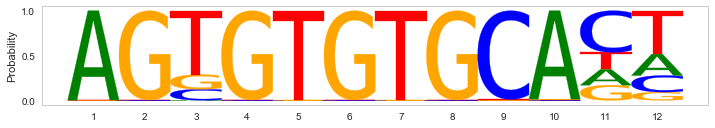

time: 425 ms


In [131]:
pwm.plotPWM();

In [8]:
len(dfh.Organism.unique())

1

time: 6.81 ms


In [24]:
dfh.DB.unique()

array(['H10MO'], dtype=object)

time: 7.83 ms


In [9]:
dfh.Organism.unique()

array(['HUMAN'], dtype=object)

time: 7.03 ms


In [17]:
grb = dfh.groupby(["Organism", "TF"]).consensus.count()

time: 6.41 ms


In [28]:
dfh['info'].unique()

array(['B', 'C', 'D', 'A', 'S'], dtype=object)

time: 6.53 ms


In [30]:
dfh = dfh[dfh['info'] != "S"]

time: 4.77 ms


In [35]:
grb = dfh.groupby(["Organism", "TF"]).consensus.count()

time: 6.78 ms


In [40]:
# all PWM's are unique
assert np.mean(grb==1) == 1

time: 3.02 ms


In [ ]:
tf-binding/<human>/pwm/HOCOMOCO

In [48]:
out_path = os.path.expanduser("~/.kipoi/models/tf-binding/human/pwm/HOCOMOCO")

time: 3.26 ms


In [50]:
os.makedirs(out_path, exist_ok=True)

time: 15.2 ms


In [178]:
def write_model(row, root_path):
    """For each pwm, write out the model
    """
    TF = row.TF
    PWM_id = row.PWM_id
    quality = row['info']
    
    model_dir = os.path.join(root_path, TF)
    os.makedirs(os.path.join(root_path, TF, "model_files"), exist_ok=True)
    
    pwm = hocomoco.get_pwm_list([PWM_id], pseudocountProb=0.001)[0]
    
    model = get_model(pwm)
    
    model.save(os.path.join(model_dir, "model_files/model.h5"))
    
    symlink_files = ["model.yaml", 
                     "example_files", 
                     "dataloader.yaml", 
                     "dataloader.py"]
    for f in symlink_files:
        os.symlink(os.path.join(root_path, "template", f),
                   os.path.join(model_dir, f))

time: 27 ms


In [179]:
import keras.layers as kl
from keras.models import Sequential

def get_model(pwm):
    """Builds a keras models with a single conv filter
    initialized to a PSSM matrix
    """
    m = Sequential([
        kl.Conv1D(filters=1, 
                  kernel_size=len(pwm.get_pssm()), 
                  activation="relu",
                  kernel_initializer="zeros",
                  bias_initializer="zeros",
                  input_shape=(None, 4),
                  name="conv1"),
        kl.GlobalMaxPooling1D()
    ])
    m.layers[0].set_weights([pwm.get_pssm()[:,:,np.newaxis], l.get_weights()[1]])
    return m

time: 13.2 ms


In [165]:
from concise.utils.plot import seqlogo_fig

time: 1.71 ms


In [154]:
m = get_model(pwm)

time: 55.8 ms


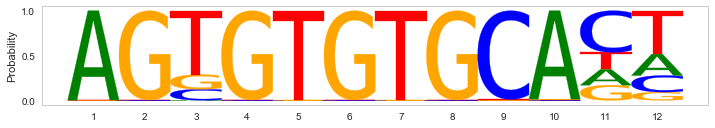

time: 419 ms


In [157]:
pwm.plotPWM();

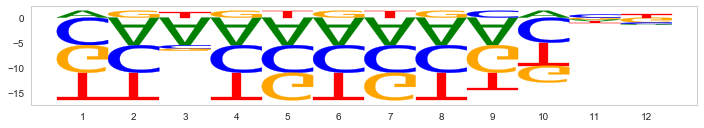

time: 405 ms


In [158]:
pwm.plotPSSM();

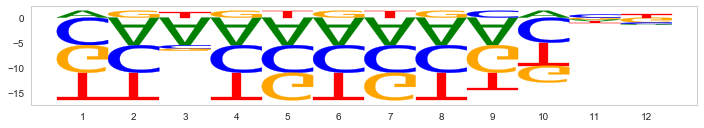

time: 428 ms


In [159]:
# Conv filters
seqlogo_fig(m.get_weights()[0][:,:,0], figsize=(10, 2));

In [ ]:
PWM.plotPSSM()

In [34]:
dfh.head

,PWM_id,TF,Organism,DB,info,consensus
0,AHR_HUMAN.H10MO.B,AHR,HUMAN,H10MO,B,GTTGCGTGC
1,AIRE_HUMAN.H10MO.C,AIRE,HUMAN,H10MO,C,ATTGGTTATATTGGTTAA
2,ALX1_HUMAN.H10MO.B,ALX1,HUMAN,H10MO,B,ATAATTGAATTA
3,ALX3_HUMAN.H10MO.D,ALX3,HUMAN,H10MO,D,TAATTTAATTA
4,ALX4_HUMAN.H10MO.D,ALX4,HUMAN,H10MO,D,TAATTTAATTAA


time: 18.4 ms


In [176]:
from tqdm import tqdm

time: 15.3 ms


In [180]:
for i in tqdm(range(len(dfh))):
    write_model(dfh.iloc[i], out_path)

100%|██████████| 600/600 [09:04<00:00,  1.10it/s]

time: 9min 4s
